## MADlib Greenplum Demo
---

### Import neccessary Data Science libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)

Connect to Greenplum Database

In [2]:
%load_ext sql

In [3]:
!minikube service list

|-------------|------------------------------------------------------|--------------|------------------------------|
|  NAMESPACE  |                         NAME                         | TARGET PORT  |             URL              |
|-------------|------------------------------------------------------|--------------|------------------------------|
| default     | agent                                                | No node port |
| default     | greenplum                                            | psql/5432    | http://192.168.133.128:32000 |
| default     | greenplum-validating-webhook-service-9d44d9fcf-t26tq | No node port |
| default     | kubernetes                                           | No node port |
| default     | my-greenplum-pl                                      | No node port |
| default     | my-greenplum-pxf                                     | No node port |
| kube-system | kube-dns                                             | No node port |
|-------------|-

In [4]:
%sql postgresql://gpadmin@192.168.133.128:32000/db

/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Check Database Data

In [5]:
%%sql


SELECT COUNT(*) AS num_sample FROM sensors;

 * postgresql://gpadmin@192.168.133.128:32000/db
1 rows affected.


num_sample
200000


In [6]:
%%sql

SELECT * FROM sensors LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:32000/db
10 rows affected.


timestamp,temperature,humidity,pm25
1997-03-22 00:00:00,30.8047161203313,58.8073039521183,70.1593314073412
1997-03-22 04:00:00,31.9898757143406,35.4666174690476,101.108855061167
1997-03-22 12:00:00,32.8135066778584,43.3584196607147,86.0795101340134
1997-03-22 20:00:00,31.6154274170955,65.4569391835045,81.4311121598402
1997-03-22 21:00:00,31.8669137997911,42.8483166734665,97.4303197662544
1997-03-22 22:00:00,30.8409907202386,33.8736024988599,83.804730037737
1997-03-23 04:00:00,31.1052825228949,42.9876265040152,41.2230321573515
1997-03-23 06:00:00,32.0551770239945,48.8782973688565,99.5943731700299
1997-03-23 08:00:00,31.826260439098,22.2934670289758,77.4061032457977
1997-03-23 12:00:00,30.2588101202541,82.7464562436005,100.19636916908


In [7]:
sensors = %sql SELECT * FROM sensors LIMIT 1000;
sensors = sensors.DataFrame()

 * postgresql://gpadmin@192.168.133.128:32000/db
1000 rows affected.


In [8]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    1000 non-null   datetime64[ns]
 1   temperature  1000 non-null   float64       
 2   humidity     1000 non-null   float64       
 3   pm25         1000 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 31.4 KB


In [9]:
sensors.describe()

,temperature,humidity,pm25
count,1000.000000,1000.000000,1000.000000
mean,31.497759,50.327933,89.945350
std,0.858299,15.297907,15.023649
min,30.008730,2.858267,38.065512
25%,30.781889,40.166314,80.297481
50%,31.498861,50.170887,90.070164
75%,32.215164,60.082615,100.166234
max,32.999716,102.371562,138.014441


/usr/local/anaconda3/envs/madlib/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


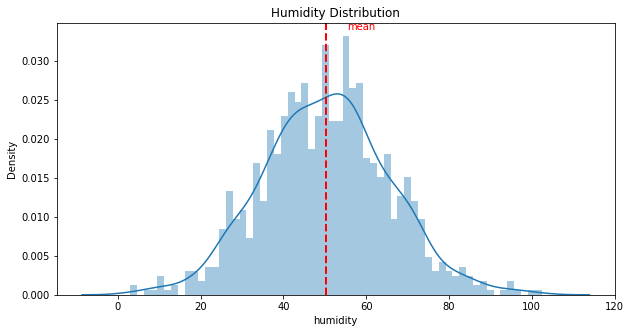

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(sensors['humidity'],bins=60);
plt.title("Humidity Distribution")
plt.axvline(x=sensors['humidity'].mean(),color='red',ls='--',lw=2)
plt.text(sensors['humidity'].mean()+5,0.034, "mean", fontsize=10,c='red');

### Preprocess Data

Encode Month

```sql
CREATE FUNCTION parse_month(time_stamp timestamp)
  RETURNS char
AS $$
  from datetime import datetime
  date_obj=datetime.strptime(time_stamp,"%Y-%m-%d %H:%M:%S")
  return date_obj.strftime("%B")
$$ LANGUAGE plpythonu;
```

In [15]:
%%sql
SELECT *,parse_month(timestamp) FROM sensors WHERE pm25 > 160;

 * postgresql://gpadmin@192.168.133.128:32000/db
3 rows affected.


timestamp,temperature,humidity,pm25,parse_month
2013-07-17 01:00:00,31.1730905372319,71.9060682541406,163.339759121527,July
2017-01-08 01:00:00,31.4313348104384,42.9120495893807,160.503965867301,January
1999-05-21 05:00:00,32.5355865309857,88.4879964462528,168.967536334876,May


Create Month Data

In [18]:
%%sql
DROP TABLE IF EXISTS sensors_pre;
CREATE TABLE sensors_pre
AS 
SELECT
    timestamp,
    temperature,
    humidity,
    pm25,
    parse_month(timestamp) AS month           --- Month data
FROM sensors;

SELECT * FROM sensors_pre LIMIT 10; 

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
200000 rows affected.
10 rows affected.


timestamp,temperature,humidity,pm25,month
1997-03-22 09:00:00,32.7567370123648,53.7069179335359,89.6222118646893,March
1997-03-22 11:00:00,30.7539767961126,47.1209740779875,75.7699431517518,March
1997-03-22 14:00:00,30.0627184404573,41.2363584988118,98.6599475653585,March
1997-03-22 19:00:00,32.4413786387966,44.6972335389847,92.7247378285515,March
1997-03-23 03:00:00,31.7391745565525,35.107108544389,84.6966582369664,March
1997-03-23 11:00:00,32.3902589709109,60.765280156387,109.233098624753,March
1997-03-23 15:00:00,31.6892189141597,41.098272445536,105.142356538178,March
1997-03-24 08:00:00,30.8341072499016,65.4908844002081,89.9127076823443,March
1997-03-24 10:00:00,31.6266345401123,42.6576511328954,85.1074155187184,March
1997-03-24 18:00:00,32.4385127874761,41.6122454978864,77.110638288745,March


In [24]:
%%sql
SELECT parse_month(timestamp) as month ,COUNT(*) as count  
    FROM sensors  
GROUP BY month ORDER BY count;

 * postgresql://gpadmin@192.168.133.128:32000/db
12 rows affected.


month,count
February,14904
April,16560
September,16560
November,16560
June,16560
March,16608
January,16688
May,17112
August,17112
December,17112


### Encode categorical values

In [26]:
%%sql
DROP TABLE IF EXISTS sensors_encoded;
SELECT
madlib.encode_categorical_variables (
    'sensors_pre',
    'sensors_encoded',
    'month'
);

 * postgresql://gpadmin@192.168.133.128:32000/db
Done.
1 rows affected.


encode_categorical_variables
""
